In [ ]:
!unzip drive/MyDrive/subreddit_comments.zip
!pip install -q torch
!pip install -q transformers
!pip install -q numpy
!pip install seaborn 

Archive:  drive/MyDrive/subreddit_comments.zip
  inflating: train_main_sub.json     
  inflating: test_main_sub.json      
     |████████████████████████████████| 1.4MB 5.4MB/s 
     |████████████████████████████████| 890kB 25.4MB/s 
     |████████████████████████████████| 2.9MB 22.0MB/s 


In [ ]:
import json
import transformers
# from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from transformers import DistilBertModel , DistilBertTokenizerFast
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import random
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with open('train_main_sub.json') as f:
  train_data_raw = json.load(f)
with open('test_main_sub.json') as f:
  test_data_raw = json.load(f)
  

In [ ]:
# Data exploration
def count_subreddit(data):
  count = {}
  for i in data["posts"]:
    cat = i['subreddit']
    if(cat in count.keys()):
      count[cat] = count[cat] + 1
    else:
      count[cat]=1
  return count     

cat_dict_train = count_subreddit(train_data_raw)
cat_dict_test = count_subreddit(test_data_raw)
print("Total subreddits in training {}".format(len(cat_dict_train.keys())))
print("Total subreddits in testing {}".format(len(cat_dict_test.keys())))
s_a = set(cat_dict_train.keys())
s_b = set(cat_dict_test.keys())

print("Missing subreddit in test but in train: {}".format(len(s_a-s_b)))
print("Missing subreddit in train but in test: {}".format(len(s_b-s_a)))
print(len(train_data_raw["posts"]))


Total subreddits in training 6801
Total subreddits in testing 3869
Missing subreddit in test but in train: 3656
Missing subreddit in train but in test: 724
6761851


In [ ]:
# balance the data sets. 
# Create training label vectors. 5:15
BALANCED_SIZE = 50
import random
def get_balanced_dataset(raw_data):
  posts={}
  cats = s_a.intersection(s_b)
  for i in raw_data["posts"]:
    if i["subreddit"] in cats:
      if i["subreddit"] in posts:
        posts[i["subreddit"]].append(i["text"])
      else:
        posts[i["subreddit"]] = [i["text"]]
  ret = []
  count = 0
  for i in posts.keys():
    if len(posts[i]) > BALANCED_SIZE:
      sampling = random.choices(posts[i], k=4)          
    else:
      sampling = posts[i]
    count = count + len(sampling)  
    for text in sampling:
      ret.append({"text":text,"subreddit":i})
  print("Total posts added is: {}".format(count))
  return {"posts":ret}

train_data_raw = get_balanced_dataset(train_data_raw)
test_data_raw = get_balanced_dataset(test_data_raw)
print(len(train_data_raw["posts"]))
# Make raw data balanced.

Total posts added is: 32689
Total posts added is: 31251
32689


In [ ]:
# Compute token length: start 4:24| done 4:49

# from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
PRE_TRAINED_MODEL_NAME = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizerFast.from_pretrained(PRE_TRAINED_MODEL_NAME)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


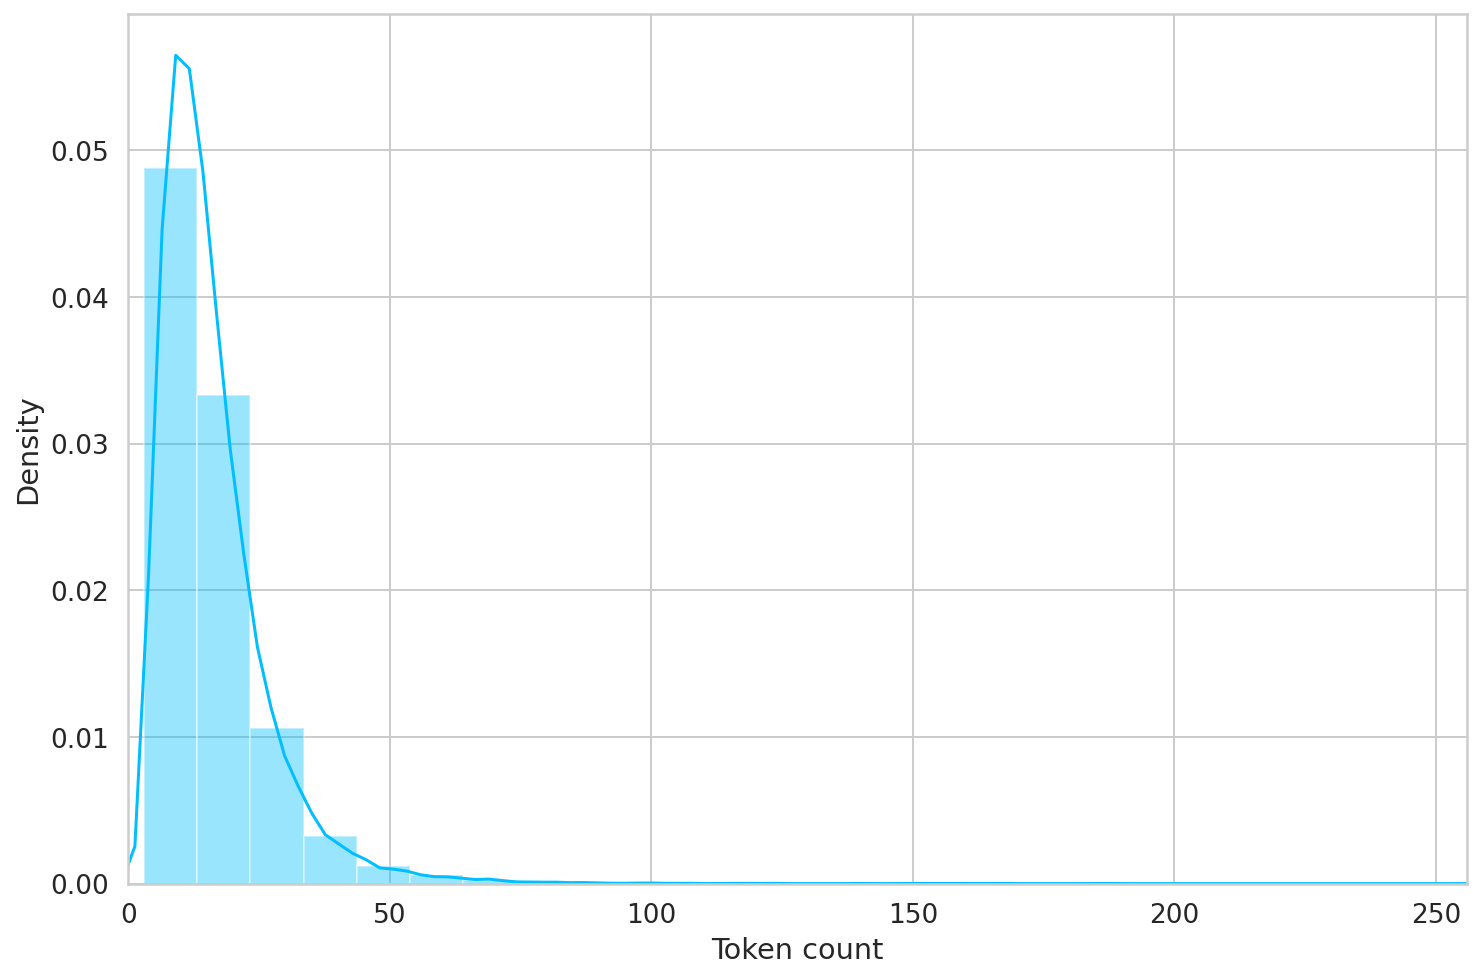

In [ ]:
token_lens = []

for txt in train_data_raw["posts"]:
  tokens = tokenizer.encode(txt["text"], max_length=512,truncation=True)
  token_lens.append(len(tokens))
  

sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

MAX_LEN = 64


In [ ]:
# Create training label vectors. 5:15
keys={}
keys['unknown'] = 0
count = 1
for i in s_a.intersection(s_b):
  keys[i] = count
  count = count + 1
known = keys.keys()

# def get_label(raw_data):
#   l = len(raw_data["posts"])
#   label = torch.zeros((l,1))
#   for i in range(l):
#     sub_reddit =  raw_data["posts"][i]['subreddit']    
#     if sub_reddit not in known:
#       label[i] = keys['unknown']
#     else:  
#       label[i] = keys[sub_reddit]
#   return label

# for i in (keys.keys()):
#   if(keys[i]==10):
#     print(keys)
# train_label = get_label(train_data_raw)
# test_label = get_label(test_data_raw)

# print(train_label.sum())
# print(test_label.sum())

In [ ]:
# Data Loaders.
class RedditDataset(Dataset):

  def __init__(self, raw_data,keys, tokenizer, max_len):
    self.raw_data = raw_data
    self.tokenizer = tokenizer
    self.max_len = max_len
    self.keys = keys

  def __len__(self):
    return len(self.raw_data["posts"])

  def __getitem__(self, item):
    reddit = str(self.raw_data["posts"][item]["text"])
    subreddit = self.raw_data["posts"][item]["subreddit"]
    if subreddit in self.keys:
      label = self.keys[subreddit]
    else:
      label = self.keys['unknown']
    encoding = self.tokenizer.encode_plus(
      reddit,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    
    return {
      'post': reddit,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(label, dtype=torch.long)

    }

def create_data_loader(raw_data, tokenizer, max_len, batch_size):
  ds = RedditDataset(
    raw_data = raw_data,
    keys = keys,
    tokenizer=tokenizer,
    max_len=max_len,
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )    
MAX_LEN = 64
BATCH_SIZE = 16

df_train, df_test = train_test_split(
  train_data_raw["posts"],
  test_size=0.01,
  random_state=RANDOM_SEED
)

print(len(df_train))
print(len(known))
import random


random.shuffle(df_train)  



train_data_loader = create_data_loader({"posts":df_train}, tokenizer, MAX_LEN, BATCH_SIZE)
# val_data_loader = create_data_loader({"posts":df_test}, tokenizer, MAX_LEN, BATCH_SIZE)  
test_data_loader = create_data_loader(test_data_raw,tokenizer, MAX_LEN,BATCH_SIZE)

32362
3146


In [ ]:
class SubRedditClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SubRedditClassifier, self).__init__()
    self.bert = DistilBertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    # for p in self.bert.parameters():
    #   p.requires_grad = False

  def forward(self, input_ids, attention_mask):
    output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
    )
    # print(output)
    hidden = output.last_hidden_state
    # pooled_output = output.pooler_output
    output = hidden[:,0,:] 
    return self.out(output)

model = SubRedditClassifier(len(known))

model = model.to(device)

In [ ]:
import time
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
  done = 0
  MAX = len(df_train)  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    s = time.time()
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    # print(targets.shape[0])
    e = time.time()
    done = done + targets.shape[0]
    print("Time taken",e-s)
    print(done,MAX)
    correct_predictions += torch.sum(preds == targets)
    print(loss,correct_predictions)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  i = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      i = i+1
      print(correct_predictions,i)
      # print(correct_predictions)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)  

In [ ]:
history = defaultdict(list)

best_accuracy = 0

EPOCHS = 4

# model.load_state_dict(torch.load('drive/best_model_state.bin'))
from transformers import AdamW,get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  # train_acc, train_loss = train_epoch(
  #   model,
  #   train_data_loader,
  #   loss_fn,
  #   optimizer,
  #   device,
  #   scheduler,
  #   len(df_train)
  # )
  # print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_test))
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  # if val_acc > best_accuracy:
  #   torch.save(model.state_dict(), 'drive/MyDrive/best_model_state.bin')
  #   best_accuracy = val_acc

Epoch 1/4
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

tensor(1) 1
tensor(1) 2
tensor(1) 3
tensor(1) 4
tensor(2) 5
tensor(2) 6
tensor(2) 7
tensor(2) 8
tensor(2) 9
tensor(2) 10
tensor(2) 11
tensor(3) 12
tensor(3) 13
tensor(3) 14
tensor(4) 15
tensor(4) 16
tensor(4) 17
tensor(4) 18
tensor(4) 19
tensor(4) 20
tensor(4) 21
tensor(4) 22
tensor(4) 23
tensor(4) 24
tensor(5) 25
tensor(5) 26
tensor(5) 27
tensor(5) 28
tensor(5) 29
tensor(5) 30
tensor(5) 31
tensor(5) 32
tensor(5) 33
tensor(5) 34
tensor(5) 35
tensor(6) 36
tensor(6) 37
tensor(6) 38
tensor(7) 39
tensor(7) 40
tensor(7) 41
tensor(7) 42
tensor(7) 43
tensor(7) 44
tensor(7) 45
tensor(7) 46
tensor(7) 47
tensor(9) 48
tensor(9) 49
tensor(9) 50
tensor(9) 51
tensor(9) 52
tensor(10) 53
tensor(10) 54
tensor(10) 55
tensor(11) 56
tensor(11) 57
tensor(11) 58
tensor(14) 59
tensor(14) 60
tensor(14) 61
tensor(14) 62
tensor(15) 63
tensor(15) 64
tensor(17) 65
tensor(17) 66
tensor(17) 67
tensor(17) 68
tensor(18) 69
tensor(19) 70
tensor(20) 71
tensor(20) 72
tensor(20) 73
tensor(20) 74
tensor(20) 75
tensor(23) 

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

tensor(1) 1
tensor(1) 2
tensor(1) 3
tensor(1) 4
tensor(2) 5
tensor(2) 6
tensor(2) 7
tensor(2) 8
tensor(2) 9
tensor(2) 10
tensor(2) 11
tensor(3) 12
tensor(3) 13
tensor(3) 14


KeyboardInterrupt: ignored

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
print("start")
torch.save(model.state_dict(),'drive/MyDrive/best_model_state_last.bin')










print("Done")

start
Done


In [ ]:
# Final Test Accuracy 
model.load_state_dict(torch.load('drive/MyDrive/best_model_state_last.bin'))
i=0
for post in train_data_raw["posts"]:
# for i in range(200,300):
#   # post = train_data_raw["posts"][i]
#   # post["text"] = "That was very funny"
#   d = {}
  encoding = tokenizer.encode_plus(
      post["text"],
      add_special_tokens = True,
      max_length = MAX_LEN, 
      return_token_type_ids = False,
      pad_to_max_length = True,
      return_attention_mask = True,
      return_tensors = 'pt'
  )
  d = {'post':post["text"],
        'input_ids': encoding['input_ids'],
       'attention_mask': encoding['attention_mask'],
       'targets':torch.tensor(keys[post["subreddit"]],dtype = torch.long)}
  input_ids = d["input_ids"].to(device)
  attention_mask = d["attention_mask"].to(device)
  targets = d["targets"].to(device)
  # print(input_ids.shape)
  outputs = model(
      input_ids = input_ids,
      attention_mask = attention_mask
  )
  preds =  torch.argmax(outputs,dim=1)
  # print(outputs)
  # print(preds)
  for k in keys:
    if(keys[k]==preds[0]):
      predicted = k
      break
  # i=i+1  
  if(post["subreddit"]==predicted):
    print("post",post["subreddit"])
    print("post",post["text"])
    print("predicted",k)
      



/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


post Eminem
post I could have sworn Paul Rosenberg took this pic
predicted Eminem
post pittsburgh
post Yes, how unusual that the participants in a Ukranian festival are white.
predicted pittsburgh
post pittsburgh
post How about property tax write-offs for developing on these properties?
predicted pittsburgh
post pittsburgh
post Great, bigger trains with more toxic materials travelling through our population centers and we got to pay for it!
predicted pittsburgh
post MTB
post Haha no dude not being able to mount a tire is totally a real and legitimate warranty claim
predicted MTB
post 30ROCK
post And approximately no one is surprised.
predicted 30ROCK
post 30ROCK
post "Comes out"
predicted 30ROCK
post 30ROCK
post Surprise!
predicted 30ROCK
post 30ROCK
post who told?
predicted 30ROCK
post 30ROCK
post What... what the hell is going on here?
predicted 30ROCK
post Delaware
post Oh you
predicted Delaware
post Delaware
post Spoiler alert: it's not very good.
predicted Delaware
post Delaware
p

In [ ]:
 reddit = str(self.raw_data["posts"][item]["text"])
    subreddit = self.raw_data["posts"][item]["subreddit"]
    if subreddit in self.keys:
      label = self.keys[subreddit]
    else:
      label = self.keys['unknown']
    encoding = self.tokenizer.encode_plus(
      reddit,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    
    return {
      'post': reddit,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(label, dtype=torch.long)

    }


6085665
3146
